# Qubit chain puched by measurements

## Introduction

Here we analyze a chain of N-spins where the end-most spins (spin 1 and spin N) are subject to periodic measurements. First we define the Hamiltonian of the chain, then we implement the simulation explicitly.

<div style="text-align: center;">
    <img src="Cimatec.png" alt="Description" style="width: 50%;"/>
    <p style="text-align: center;"><strong>Figure 1:</strong> Example circuit for our monitoring process.</p>
</div>

## Simulation

### Hamiltonians

#### Initial model

The Hamiltonian of a Heisenberg model is given by
\begin{equation}
    H_{Heisenberg} = - \frac{1}{2} \sum_{j=1}^{N-1} \Big( J_x^j X_j X_{j+1} + J_y^j Y_j Y_{j+1} + J_z^j Z_j Z_{j+1} \Big)
\end{equation}
where a term $-h \sum_{j=1}^N Z_j$ can be added in the presence of a magnetic field along the z-axis. However, we leave this case for a later moment.

#### Simplification

Since we are interested in measuring spins 1 and N, let us isolate the terms corresponding to them explicitly:
\begin{equation}
\begin{split}
    H_{Heisenberg} &= - \frac{1}{2} \Big( J_x^1 X_1 X_2 + J_y^1 Y_1 Y_2 + J_z^1 Z_1 Z_2 \Big) - \frac{1}{2} \sum_{j=2}^{N-2} \Big( J_x^j X_j X_{j+1} + J_y^j Y_j Y_{j+1} + J_z^j Z_j Z_{j+1} \Big) -\\
    &- \frac{1}{2} \Big( J_x^{N-1} X_{N-1} X_N + J_y^{N-1} Y_{N-1} Y_N + J_z^{N-1} Z_{N-1} Z_N \Big)
\end{split}
\end{equation}

Now we simplify our initial analysis by considering that the intermediate spins obey the Ising model, i.e. $J_j^x = J_j^y = 0$. Moreover, we also set $J_1^z = J_1^y = 0$ and $J_{N-1}^x = J_{N-1}^y = 0$. This means that spin 1 can only be aligned to the x-axis and all other spins to the z-axis. Thus, incorporating the factor of 1/2 into the coupling constants and setting $J_z^j = J_z$ and $J_x^1 = J_x$, we are left with
\begin{equation}
    H = - J_x X_1 X_2 - \sum_{j=2}^{N-2} J_z Z_j Z_{j+1} - J_z Z_{N-1} Z_N
\end{equation}

Finally, we can consider two cases, an _open_ chain, where qubit 1 and qubit N do not interact, and a _closed_ (periodic) chain, where they do. In the former case, the Hamiltonian is simply $H \equiv H_{open}$ above. In the later, we add a term $- J_z Z_N Z_1$ to $H$, so that we are left with
\begin{equation}
\begin{split}
    H_{open} &= - J_x X_1 X_2 - \sum_{j=2}^{N-2} J_z Z_j Z_{j+1} - J_z Z_{N-1} Z_N\\
    H_{closed} &= - J_x X_1 X_2 - \sum_{j=2}^{N-2} J_z Z_j Z_{j+1} - J_z Z_{N-1} Z_N - J_z Z_N Z_1
\end{split}
\end{equation}

### Defining parameters

In [32]:
# Defining system parameters
num_spins = 3
J_x = 1
J_z = 1

### Visualizing chains

In qiskit the chains are implemented as `CouplingMap` instances, based on the importance of these systems to build the architecture of quantum processors. The idea is to represent our chains as computer science _graphs_, where each qubit is a vertex and each edge connecting two vertices is an interaction.

#### Open chain

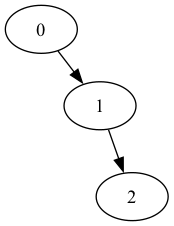

In [33]:
from qiskit.transpiler import CouplingMap

# Open chain
open_chain = CouplingMap.from_line(num_qubits=num_spins, bidirectional=False)
open_chain.draw()

#### Closed chain

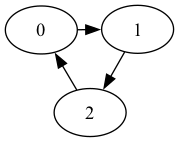

In [34]:
# Closed chain
closed_chain = CouplingMap.from_ring(num_qubits=num_spins, bidirectional=False)
closed_chain.draw()

### Implementing Hamiltonians

In [35]:
from qiskit.quantum_info import SparsePauliOp

# Listing edges
open_edgelist = open_chain.graph.edge_list()
closed_edgelist = closed_chain.graph.edge_list()

# Building Hamiltonians
open_hamlist = []
closed_hamlist = []

## Open chain
open_hamlist.append(('XX', open_edgelist[0], -J_x)) # Spin 1

for edge in open_edgelist[1:num_spins-1]:
    open_hamlist.append(('ZZ', edge, -J_z)) # Spin 2 to N

open_hamiltonian = SparsePauliOp.from_sparse_list(obj=open_hamlist, num_qubits=num_spins)

## Closed chain
closed_hamlist.append(('XX', closed_edgelist[0], -J_x)) # Spin 1

for edge in closed_edgelist[1:num_spins-1]:
    closed_hamlist.append(('ZZ', edge, -J_z)) # Spins 1 to N-1

closed_hamlist.append(('XX', closed_edgelist[num_spins-1], -J_z)) # Spin N

closed_hamiltonian = SparsePauliOp.from_sparse_list(obj=closed_hamlist, num_qubits=num_spins)

# Storing Hamiltonians into a dictionary
H_dict = {'Open chain': open_hamiltonian, 'Closed chain': closed_hamiltonian}

print(open_hamiltonian)
print(closed_hamiltonian)

SparsePauliOp(['IXX', 'ZZI'],
              coeffs=[-1.+0.j, -1.+0.j])
SparsePauliOp(['IXX', 'ZZI', 'XIX'],
              coeffs=[-1.+0.j, -1.+0.j, -1.+0.j])


### Implementing time-evolution

#### Trotterization

Now we need to represent the time-evolution operator of our chains, $U = e^{-i H \delta t}$, as a quantum circuit. This can be done by getting the matrix form of the Hamiltonian of each system and exponentiating them to define both $U$'s as gates acting on $N$ qubits directly. However, this method is not scallabe, and can become impractical when $N$ is large. This is why we must use _trotterization_ to approximate $U$ efficiently.

In [36]:
from qiskit.circuit import Parameter
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import LieTrotter

# Time-evolution parameter
dt = Parameter('ẟt')

# Number of trotterization layers
trotter_factory = LieTrotter(reps=4)

# Open chain
open_U = PauliEvolutionGate(open_hamiltonian, time=dt)
open_U_qc = trotter_factory.synthesize(open_U)

# Closed chain
closed_U = PauliEvolutionGate(closed_hamiltonian, time=dt)
closed_U_qc = trotter_factory.synthesize(closed_U)

# Storing time-evolution operators into a dictionary
U_dict = {'Open chain': open_U_qc, 'Closed chain': closed_U_qc}

#### Drawing the circuits

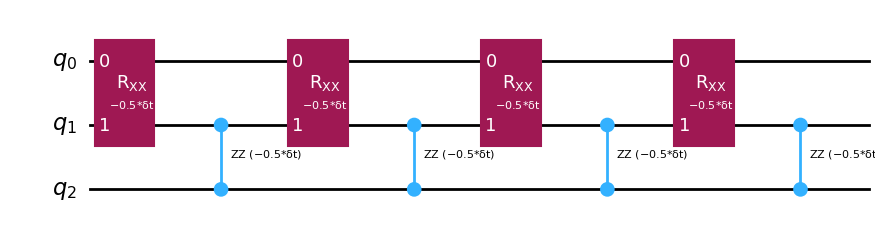

In [37]:
# Time-evolution circuit for an open chain
open_U_qc.decompose().draw('mpl')

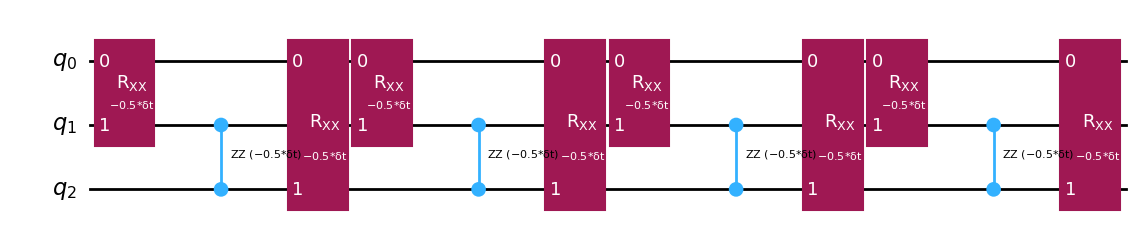

In [38]:
# Time-evolution circuit for a closed chain
closed_U_qc.decompose().draw('mpl')

### Implementing simulation

Below we start by creating a dictionary to prepare our circuits for each chain, as exemplified in Fig. 1. Calling a _step_ the compund process of a time-evolution followed by a measurement, we prepare, for each, case a circuit containing no steps, a circuit containing 1 step, a circuit containing 2 steps, and so on. Then we transpile these circuits, as well as our Hamiltonians, to our target backend, which will be for now the `AerSimulator`. Then we simulate the circuits using the `Estimator` primitive and plot the results.

In [44]:
from qiskit.circuit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from tqdm import tqdm

# Parameters for the simulation
time_step = 0.5
num_steps = 15
num_trajectories = 1

# Defining circuits
staged_qcs = {'Open chain': [], 
              'Closed chain': []}

for key in staged_qcs.keys():
    qc = QuantumCircuit(num_spins, 2)
    staged_qcs[key].append(qc)
    for i in range(num_steps):
        qc = qc.compose(U_dict[key])
        qc.measure([0, num_spins-1], [0, 1])
        staged_qcs[key].append(qc)

# Calling backend and pass manager
backend = AerSimulator()
pass_manager = generate_preset_pass_manager(optimization_level=2, backend=backend)
estimator = Estimator(mode=backend)

# Transpiling circuits
isa_circuits = {'Open chain': [ pass_manager.run(circuit) for circuit in staged_qcs['Open chain'] ],
                'Closed chain': [ pass_manager.run(circuit) for circuit in staged_qcs['Closed chain'] ]}

# Transpiling observables
isa_observables = {'Open chain': [ H_dict[key].apply_layout(circuit.layout) for circuit in isa_circuits['Open chain'] ],
                   'Closed chain': [ H_dict[key].apply_layout(circuit.layout) for circuit in isa_circuits['Closed chain'] ]}

# Defining PUBs
chain_pubs = {'Open chain': [(isa_circuits['Open chain'][0], isa_observables['Open chain'][0])],
              'Closed chain': [(isa_circuits['Closed chain'][0], isa_observables['Open chain'][0])]}

chain_pubs = {'Open chain': [(isa_circuits['Open chain'][0], isa_observables['Open chain'][0])] + [ (isa_qc, isa_obs, time_step) for isa_qc, isa_obs in zip(isa_circuits['Open chain'][1:], 
                                                                                   isa_observables['Open chain'][1:]) ],
              'Closed chain': [(isa_circuits['Closed chain'][0], isa_observables['Closed chain'][0])] + [ (isa_qc, isa_obs, time_step) for isa_qc, isa_obs in zip(isa_circuits['Closed chain'][1:], 
                                                                                     isa_observables['Closed chain'][1:]) ]}

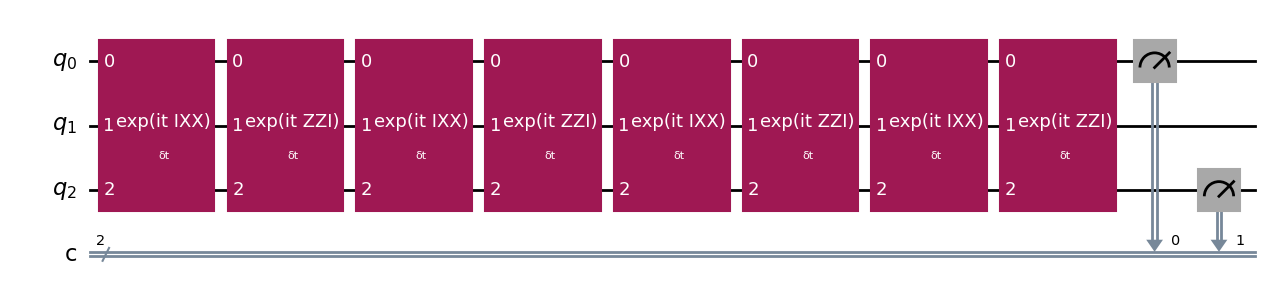

In [48]:
staged_qcs['Open chain'][1].draw('mpl')

In [45]:
import numpy as np
# Simulating circuits

# Dictionary to store simulation result and parameters
expvals = {'num_spins': num_spins, 
           'num_steps': num_steps,
           'num_trajectories': num_trajectories,
           'backend': backend.name,
           'time_step': time_step,
           'Open chain': np.zeros(num_steps+1), 
           'Closed chain': np.zeros(num_steps+1)}

for i in tqdm(range(num_trajectories), desc='Trajectory'):

    open_job = estimator.run(pubs=chain_pubs['Open chain'])
    closed_job = estimator.run(pubs=chain_pubs['Closed chain'])
    
    for j in range(num_steps+1):
        expvals['Open chain'][j] += open_job.result()[j].data.evs/num_trajectories
        expvals['Closed chain'][j] += closed_job.result()[j].data.evs/num_trajectories

Trajectory: 100%|█████████████████████████████████| 1/1 [00:01<00:00,  1.62s/it]


#### Saving results into a file

In [46]:
# import json

# # Converting expvals to standard python list
# expvals['Open chain'] = list(expvals['Open chain'])
# expvals['Closed chain'] = list(expvals['Closed chain'])

# # Saving data
# filename = '{}_spins-{}_steps-{}_trajectories-dt={}.json'.format(num_spins, num_steps, num_trajectories, time_step)
# with open(filename, 'w') as file:
#     json.dump(expvals, file)
    
# # Code to load dictionary from a json file
# # import json

# # with open('data.json', 'r') as file:
# #     loaded_dict = json.load(file)

#### Plotting results

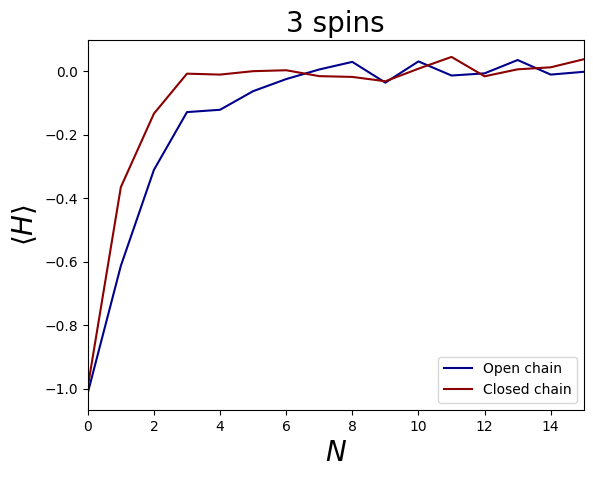

In [47]:
import matplotlib.pyplot as plt

steps = list(range(num_steps+1))

# Plotting energies
plt.plot(steps, expvals['Open chain'], color = 'darkblue', label='Open chain')
plt.plot(steps, expvals['Closed chain'], color = 'darkred', label='Closed chain')

# Customizing axes
plt.title('{} spins'.format(num_spins), fontsize=20)
plt.xlabel(r'$N$', fontsize=20)
plt.ylabel(r'$\langle H \rangle$', fontsize=20)
plt.xlim(0, num_steps)
plt.legend(loc='lower right')

# Show the plot
plt.show()